# 2. Training eines MLPs auf den Spielzeugdaten
Der Code aus dem Beispielnotebook muss zunächst an das Szenario aus der Vorlesung angepasst werden: ein deutlich kleineres Netzwerk mit eindimensionalem statt zehndimensionalem Output.

Vorgehensweise:

1. Setzen Sie im Code die Größe der Minibatches auf 10, die Anzahl der Epochen auf 150 und die Lernrate auf 0.03. Ändern Sie die Netzarchitektur so ab, dass sie 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron haben. Überprüfen Sie die Größen der sich daraus ergebenden Gewichtsmatritzen auf Korrektheit.


2. Der Beispielcode verwendet One-Hot-Coding für die Labels, in unserem Beispiel sind die Klassenzugehörigkeiten aber durch die Klassenindizes 0 und 1 codiert. Wir müssen daher die Funktion `evaluate()` im Code so abändern, dass ein Beispiel als korrekt klassifiziert gilt, wenn bei Klasse 0 der MLP-Output kleiner als 0.5 ist und bei Klasse 1 größer als 0.5. Berechnen Sie zusätzlich den MSE in dieser Funktion bei jedem Aufruf uns speichern Sie diesen in einem zusätzlichen Array ab.

3. Trainieren Sie Ihr Netz mit den Trainingsdaten als Validierungsdaten und testen Sie es auf Ihren Testdaten. Stellen Sie die Lernkurven für Genauigkeit und MSE als Plots dar. Beachten Sie hierbei, dass unser Lernproblem nicht konvex ist, so dass die Optimierung zuweilen in lokalen Minima hängenbleiben kann. Wiederholen Sie Ihren Versuch daher mehrere Male und vergeleichen Sie die Ergebnisse.

4. Berechnen Sie die Entscheidungsfunktion Ihres MLPs für Ihr 100 × 100-Gitter und stellen Sie diese gemeinsam mit dem Scatterplot Ihrer Trainingsdaten dar.

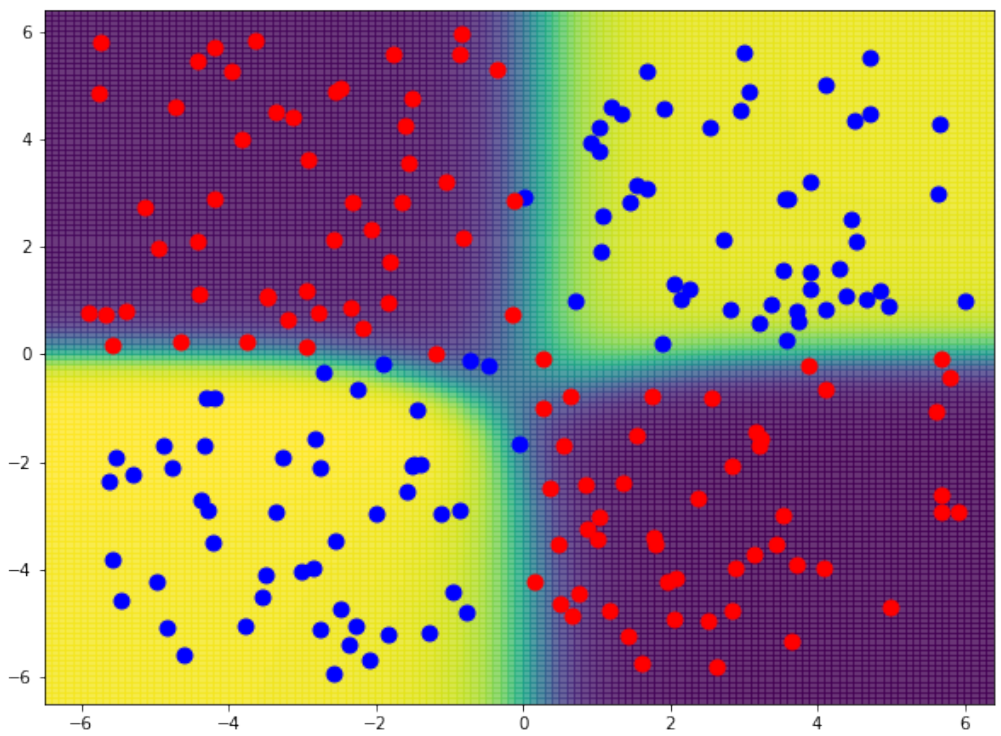